# Implementing a saliency map for nlp

As per the assignment, a saliency map was calulated and generated using pytorch functions. The aim was to learn how to manipulate a pytorch model, extract gradients, and explore the area of model explainability. I used the assignment to do my own further analysis in model explainability. **In the assignment, we evaluated the semtiment model trained to predict the moral utility of a statement. This project extends the assignment by evaluating a different model and adding further analysis.**


1. This notebook first uses `thermostat` with the imdb sentiment model. This is an example of a saliency map (it visualises a tokens importance to the output).

2. Then the notebook illustrates how a saliency map can be made by computing the gradients. This is the homework assignment. This visualisation shows to what extent a specific token negatively or positively impacts  

3. Finally, the notebook contains example analysis using the method on the **Deberta model finetuned on utilitarian ethics**(Further analysis on hate speech classifier is separated for readability).

## 1. Saliency Map with Thermostat

https://github.com/DFKI-NLP/thermostat

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import thermostat 

### 1.1 Load the artifacts for the thermostat example/ demo

In [15]:
data = thermostat.load("imdb-bert-lig")
print(data)

IMDb dataset, BERT model, Layer Integrated Gradients explanations
Dataset: imdb
Model: textattack/bert-base-uncased-imdb
Explainer: LayerIntegratedGradients



This is an an instance of the dataset and visualisation we want to emulate for a new dataset 

The saliency map visualisaes the the attribution score. It iis how the specific token positively or negatively impacts the final prediction

In [16]:
instance = data[250]

print(f'Index: {instance.idx}')
print(f'Attributions (first 5): {instance.attributions[:5]}')
print(f'True label: {instance.true_label}')
print(f'Predicted label: {instance.predicted_label}')

Index: 250
Attributions (first 5): [0.0, 0.2166113704442978, 0.034326110035181046, 0.1554376184940338, 0.06493246555328369]
True label: pos
Predicted label: pos


In [17]:
instance.render() # Visualisation

## 2. Analysing a new dataset: 

The outline of the homework task was
1.  We will be loading the model and corresponding tokenizer.  Note that the model and tokenizers go hand in hand.
2.  We will compute the gradients of the model and write up a description of what it means.
3.  We will recreate the above renderer to be able to display the utility of each word.
4. We will be examining some inconsistencies or failures of current language models.
5. We will ask you to see if you can discover any other inconsistencies yourself. 

In [ ]:
# Run this if you get duplicate file name (sentencepiece_model.proto)
# !pip uninstall protobuf
# !pip install --no-binary=protobuf protobuf #issue with protobuf binary wheels

### 2.1 Loading the models

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.manual_seed(42)

/Users/tania/opt/anaconda3/envs/saliency-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("pfr/utilitarian-deberta-01")
model = AutoModelForSequenceClassification.from_pretrained("pfr/utilitarian-deberta-01")

### 2.2 Measuring Utility

In [5]:
def print_utility(sequences, utilities):
    for sequence, utility in zip(sequences, utilities):
        print(f'"{sequence}" has utility {utility}')

In [78]:
max_length = 64
num_gpus = 0

#Sample sentences and their utility values as predicted by the model (the utility value is simply the model output/logit)
sentences = ["A meteor hit the Earth and Earth exploded.", 
             "A meteor wiped out all life on Earth.", 
             "I found a cure to all diseases.", 
             "I killed 1000 people."]

inputs = tokenizer(sentences, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    utilities = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])['logits']
    

print_utility(sentences, utilities)

"A meteor hit the Earth and Earth exploded." has utility tensor([-12.6104])
"A meteor wiped out all life on Earth." has utility tensor([-12.2945])
"I found a cure to all diseases." has utility tensor([7.3104])
"I killed 1000 people." has utility tensor([-7.8252])


### 2.3 Computing the Gradient

In [12]:
## These functions were explained and provided as part of the homework!

def _register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.deberta.embeddings.word_embeddings
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def _register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0])
    embedding_layer = model.deberta.embeddings.word_embeddings
    hook = embedding_layer.register_backward_hook(hook_layers)
    return hook

In [53]:
## I had to implement this function for the homework

def get_saliency_map(model, input_ids, token_type_ids, input_mask):
    torch.enable_grad()
    model.eval()
    embeddings_list = []
    handle = _register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = _register_embedding_gradient_hooks(model, embeddings_gradients)

    model.zero_grad()
    
    output = model(input_ids, attention_mask=input_mask) 
    output['logits'][0].backward() 

    handle.remove()
    hook.remove()

    saliency_grad = embeddings_gradients[0].detach().cpu().numpy()        
    saliency_grad = np.sum(saliency_grad * embeddings_list[0], axis=-1)
    norm = np.linalg.norm(saliency_grad, ord=1)
    saliency_grad = [e / norm for e in saliency_grad] 
    
    return saliency_grad

In [136]:
## For the purposes of the project, I added a new function for ease of use
def calculate_single_saliency(model, inputs, input_index=0):
    return get_saliency_map(model, inputs['input_ids'][input_index].unsqueeze(0), inputs['token_type_ids'][input_index].unsqueeze(0), inputs['attention_mask'][input_index].unsqueeze(0))

def calculate_saliencies(model, inputs):
    n = len(inputs['input_ids'])
    return [calculate_single_saliency(model, inputs, input_index=i)[0] for i in range(n)]

### 2.4 Visualise the Gradient

In [137]:
#saliency_maps = calculate_single_saliency(model, inputs)
saliency_maps = calculate_saliencies(model, inputs)

/Users/tania/opt/anaconda3/envs/saliency-env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [76]:
def visualize(tokens, saliency_map):
    y = saliency_map[:len(tokens)]
    x = [i for i in range(len(tokens))]
    plt.bar(x, y)
    plt.xticks(x, tokens)

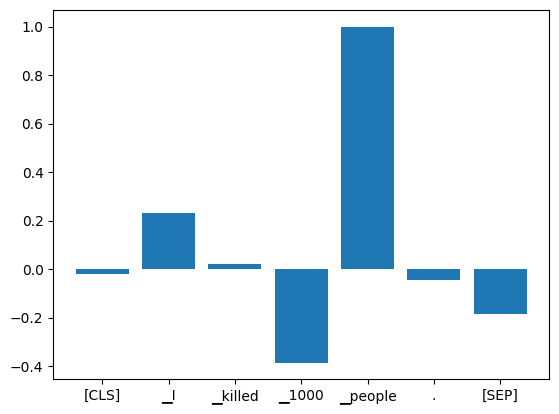

In [139]:
i = 3
visualize(tokenizer.tokenize(sentences[i], add_special_tokens=True), saliency_maps[i])

# Inconsitencies or Model Failures

### Inconsistency with Scope Intensity
You should expect some monotonic behaviour with some things.  The model however expresses odd behavior that isn't monotonic in its outputs.

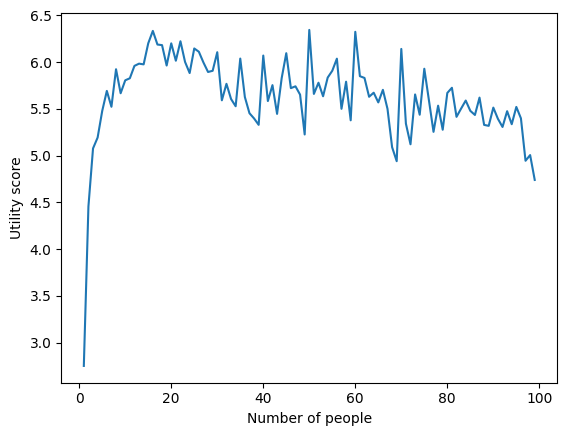

In [21]:
input_sents = [f'I saved {i} people' for i in np.arange(1, 100, 1)]

inputs = tokenizer(input_sents, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

plt.plot(np.arange(1, 100), output_utils)
plt.xlabel('Number of people')
plt.ylabel('Utility score')
plt.show()

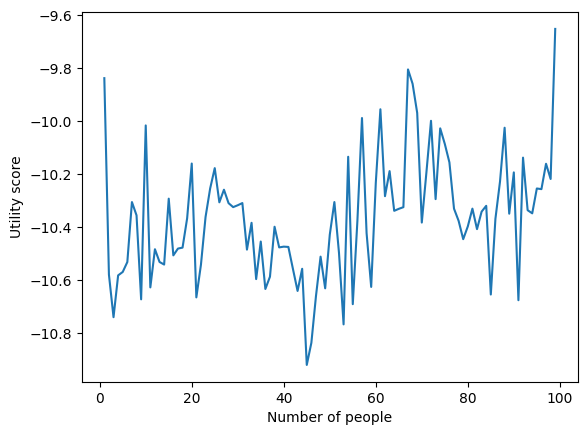

In [22]:
input_sents = [f'I killed {i} people' for i in np.arange(1, 100, 1)]

inputs = tokenizer(input_sents, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

plt.plot(np.arange(1, 100), output_utils)
plt.xlabel('Number of people')
plt.ylabel('Utility score')
plt.show()

### Framing the problem
Even if two sentences express the same idea or concept they can have very different utilities which is not a useful property if we want the model to reflect the true utility.

In [23]:
sentences = ['I performed surgery on a patient with a 50% chance of success.',
             'I performed surgery on a patient with a 50% chance of failure.']

inputs = tokenizer(sentences, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

print_utility(sentences, output_utils)

"I performed surgery on a patient with a 50% chance of success." has utility tensor([-5.1885])
"I performed surgery on a patient with a 50% chance of failure." has utility tensor([-9.4754])


### Inconsistencies in utility functions: Distracted by noise AND/OR biased by characters

In [35]:
sentences = ['I won $100,000.', 'I won $101,101.', 'I won 100,000.', 'I won 101,101.', 'I won $0.', 'I won 0.']
sentences = sentences + [s.strip('.') for s in sentences]

inputs = tokenizer(sentences, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

print_utility(sentences, output_utils) # its utility score is so much higher than saving lives (?)

"I won $100,000." has utility tensor([11.4402])
"I won $101,101." has utility tensor([10.1360])
"I won 100,000." has utility tensor([10.6114])
"I won 101,101." has utility tensor([4.0908])
"I won $0." has utility tensor([1.1805])
"I won 0." has utility tensor([0.1906])
"I won $100,000" has utility tensor([10.2561])
"I won $101,101" has utility tensor([8.8332])
"I won 100,000" has utility tensor([9.1089])
"I won 101,101" has utility tensor([2.3084])
"I won $0" has utility tensor([-0.8088])
"I won 0" has utility tensor([-0.3741])


/Users/tania/opt/anaconda3/envs/saliency-env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


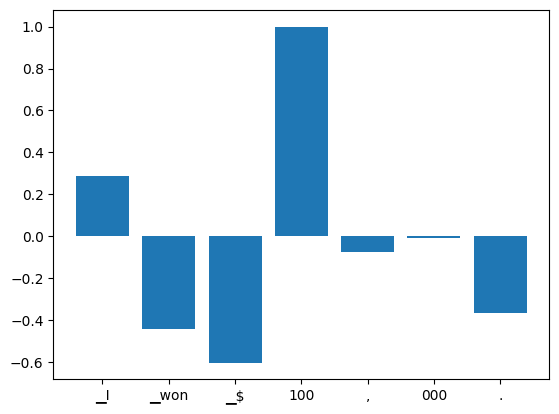

In [37]:
saliency_maps = get_saliency_map(model, inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'])
visualize(tokenizer.tokenize(sentences[0]), saliency_maps[0])

## Bias
The utility function might also present bias that is similar to what humans might have.

**Gender/Age**

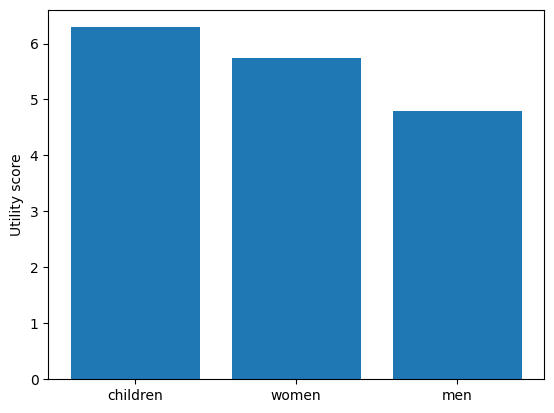

In [28]:
sentence = 'I saved 1,000,000 [MASK]\'s lives today'

input_sents = [sentence.replace('[MASK]', s) for s in ['children', 'women', 'men']]

inputs = tokenizer(input_sents, max_length=max_length, padding='max_length', return_tensors='pt')
with torch.no_grad():
    output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

plt.bar(range(3), output_utils.flatten(), tick_label=['children', 'women', 'men'])
plt.ylabel('Utility score')
plt.show() # As this is utilitarian model the bias should not exist

**Race/Gender**

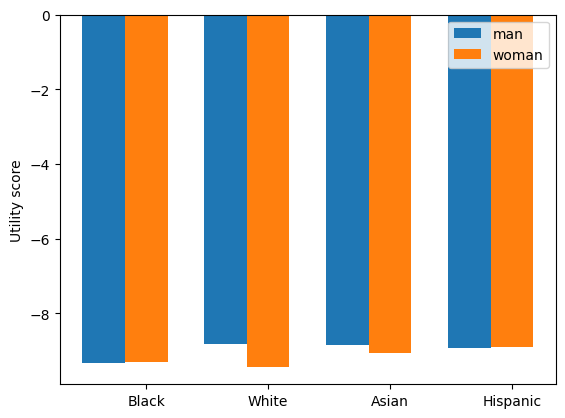

In [141]:
def gender_bias(isMan: bool):
    gender = 'man' if isMan else 'woman'
    indent = 0 if isMan else 1

    race = ['Black', 'White', 'Asian', 'Hispanic']

    sentence = f'[MASK] {gender} dies.'

    input_sents = [sentence.replace('[MASK]', s) for s in race]

    inputs = tokenizer(input_sents, max_length=max_length, padding='max_length', return_tensors='pt')
    with torch.no_grad():
        output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]

    bar_width = 0.35

    plt.bar(np.arange(len(race)) + bar_width * indent, output_utils.flatten(), bar_width, tick_label=race, label=gender)
    plt.ylabel('Utility score')

gender_bias(True)
gender_bias(False)
plt.legend()
plt.show()

### Further Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


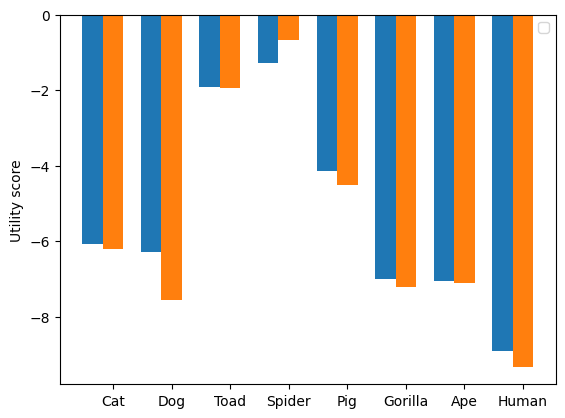

In [142]:
def animal_bias(adjective: str, indent):

    species = ['Cat', 'Dog', 'Toad', 'Spider', 'Pig', 'Gorilla', 'Ape', 'Human']

    sentence = f'I killed a {adjective} [MASK].'

    input_sents = [sentence.replace('[MASK]', s) for s in species]
    inputs = tokenizer(input_sents, max_length=max_length, padding='max_length', return_tensors='pt')
    with torch.no_grad():
        output_utils = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0]


    bar_width = 0.35

    plt.bar(np.arange(len(species)) + bar_width * indent , output_utils.flatten(), bar_width, tick_label=species)
    plt.ylabel('Utility score')

animal_bias("Big", 0)
animal_bias("Small", 1)
plt.legend()
plt.show()